In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import random

import torch
from torch import nn, optim 
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

import seaborn as sns

import os
os.environ['PYTHONHASHSEED'] = str(42)
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from fast_ml.model_development import train_valid_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

In [2]:
def plot_reservoir_chart(df):
    reservoir_types = {}
    for host in df['Reservoir']:
        if host in reservoir_types.keys():
            reservoir_types[host] += 1
        else:
            reservoir_types[host] = 1

    labels = list(reservoir_types.keys())
    counts = list(reservoir_types.values())
    plt.pie(counts,labels=labels, labeldistance=None)
    ax = plt.gca()
    plt.legend(bbox_to_anchor=(1.1, 0.9), bbox_transform=ax.transAxes)
    plt.title('Distribution of Reservoir in Filtered Dataframe')
    plt.show()

# Data Visualisation/Preprocessing


In [3]:
df = pd.read_csv('BabayanEtAl_VirusData.csv')
#print(df.describe())

In [18]:
feature_list = list(df.columns)
feature_list = feature_list[1:] # remove first entry which is 'Reservoir'
print(len(feature_list))
print(feature_list)

4229
['CpG', 'UpA', 'ApA', 'ApC', 'ApG', 'ApU', 'CpA', 'CpC', 'CpU', 'GpA', 'GpC', 'GpG', 'GpU', 'UpC', 'UpG', 'UpU', 'brApA', 'brApC', 'brApG', 'brApU', 'brCpA', 'brCpC', 'brCpG', 'brCpU', 'brGpA', 'brGpC', 'brGpG', 'brGpU', 'brUpA', 'brUpC', 'brUpG', 'brUpU', 'NonBrApA', 'NonBrApC', 'NonBrApG', 'NonBrApU', 'NonBrCpA', 'NonBrCpC', 'NonBrCpG', 'NonBrCpU', 'NonBrGpA', 'NonBrGpC', 'NonBrGpG', 'NonBrGpU', 'NonBrUpA', 'NonBrUpC', 'NonBrUpG', 'NonBrUpU', 'AAA.K..AAA.K.', 'AAA.K..AAC.N.', 'AAA.K..AAG.K.', 'AAA.K..AAT.N.', 'AAA.K..ACA.T.', 'AAA.K..ACC.T.', 'AAA.K..ACG.T.', 'AAA.K..ACT.T.', 'AAA.K..AGA.R.', 'AAA.K..AGC.S.', 'AAA.K..AGG.R.', 'AAA.K..AGT.S.', 'AAA.K..ATA.I.', 'AAA.K..ATC.I.', 'AAA.K..ATG.M.', 'AAA.K..ATT.I.', 'AAA.K..CAA.Q.', 'AAA.K..CAC.H.', 'AAA.K..CAG.Q.', 'AAA.K..CAT.H.', 'AAA.K..CCA.P.', 'AAA.K..CCC.P.', 'AAA.K..CCG.P.', 'AAA.K..CCT.P.', 'AAA.K..CGA.R.', 'AAA.K..CGC.R.', 'AAA.K..CGG.R.', 'AAA.K..CGT.R.', 'AAA.K..CTA.L.', 'AAA.K..CTC.L.', 'AAA.K..CTG.L.', 'AAA.K..CTT.L.', 'A

In [4]:
df = df[df['Reservoir'].notna()] #remove nan from reservoir
df.drop(columns = ['Virus name', 'Genbank accession', 'Viral group', 'Vector-borne', 'Vector'], inplace = True)
print('# of Entries in df = {}'.format(len(df)))
print(df.head())


# of Entries in df = 534
  Reservoir       CpG       UpA       ApA       ApC       ApG       ApU  \
0    Rodent  0.273332  0.610948  1.008116  0.982968  1.102821  0.916422   
1    Rodent  0.271883  0.556632  1.147643  0.963959  1.077809  0.806347   
2    Rodent  0.242131  0.480134  1.079250  0.981423  1.040453  0.889428   
3    Rodent  0.197870  0.606717  1.060972  0.955761  1.097001  0.888032   
4    Rodent  0.186029  0.535157  1.059094  1.015957  1.034448  0.889518   

        CpA       CpC       CpU  ...  TCG.Bias  TCT.Bias  TGA.Bias  TGC.Bias  \
0  1.410025  1.024852  1.117820  ...  0.039711  0.198556      0.00  0.402174   
1  1.283400  1.105659  1.197583  ...  0.018519  0.303704      0.25  0.303030   
2  1.445752  0.947255  1.189313  ...  0.054348  0.130435      0.50  0.320000   
3  1.306677  1.098326  1.179541  ...  0.029508  0.209836      0.00  0.318681   
4  1.407899  1.032459  1.133332  ...  0.054348  0.195652      0.50  0.269231   

   TGG.Bias  TGT.Bias  TTA.Bias  TTC.Bias  

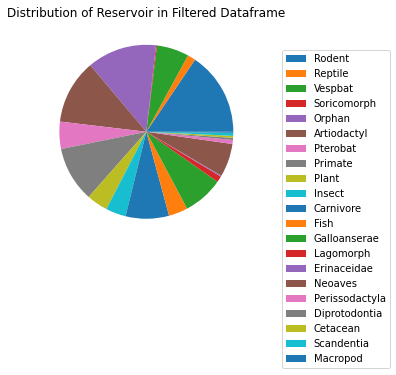

In [6]:
plot_reservoir_chart(df)

### Removing Reservoirs with counts < 15 and 

##### 1. Remove Orphans Reservoirs

##### This leaves us with 11 taxas in the end

Entries in Filtered Dataframe = 437


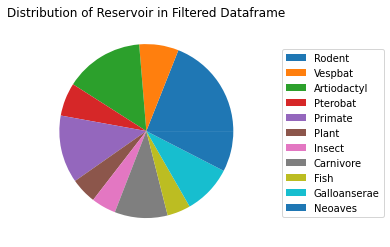

In [5]:
df = df.groupby('Reservoir').filter(lambda x : len(x) >= 15)
df.drop(df[df['Reservoir'] == 'Orphan'].index, inplace=True)

print('Entries in Filtered Dataframe = {}'.format(len(df)))
plot_reservoir_chart(df)

### Converting reservoir type of each sample to a respective number

In [6]:
diff_reservoir = df.Reservoir.unique().tolist()

for host in diff_reservoir:
    df['Reservoir'].replace({host:diff_reservoir.index(host)+2},inplace = True)
    
#df.to_csv("SEAN_Babayan_VirusData.csv" ,index = False)
#df1 = pd.DataFrame(diff_reservoir)
#df1.to_csv("SEAN R+2_ZB4171 HostTable.csv", index = True)

print(df.head())


   Reservoir       CpG       UpA       ApA       ApC       ApG       ApU  \
0          2  0.273332  0.610948  1.008116  0.982968  1.102821  0.916422   
1          2  0.271883  0.556632  1.147643  0.963959  1.077809  0.806347   
2          2  0.242131  0.480134  1.079250  0.981423  1.040453  0.889428   
3          2  0.197870  0.606717  1.060972  0.955761  1.097001  0.888032   
4          2  0.186029  0.535157  1.059094  1.015957  1.034448  0.889518   

        CpA       CpC       CpU  ...  TCG.Bias  TCT.Bias  TGA.Bias  TGC.Bias  \
0  1.410025  1.024852  1.117820  ...  0.039711  0.198556      0.00  0.402174   
1  1.283400  1.105659  1.197583  ...  0.018519  0.303704      0.25  0.303030   
2  1.445752  0.947255  1.189313  ...  0.054348  0.130435      0.50  0.320000   
3  1.306677  1.098326  1.179541  ...  0.029508  0.209836      0.00  0.318681   
4  1.407899  1.032459  1.133332  ...  0.054348  0.195652      0.50  0.269231   

   TGG.Bias  TGT.Bias  TTA.Bias  TTC.Bias  TTG.Bias  TTT.Bias 

#### Creating 11 Separate Dataframes for each Class. Each DF will indicate a binary check against Reservoir column. For instance, df_Rodent represents the Rodent DF. Samples belonging to Rodent reservoirs are indicated as 1, while all other types are indicated as 0

In [7]:
df_list = []
for i in range(11):
    copy = df.copy(deep = True)
    for entry in copy['Reservoir'].unique():
        if entry != i+2:
            copy['Reservoir'].replace({entry:0}, inplace = True)
        else:
            copy['Reservoir'].replace({i+2:1},inplace = True)
    globals()['df_' + diff_reservoir[i]] = copy
    df_list.append('df_'+ diff_reservoir[i])
    
print(df_list)

['df_Rodent', 'df_Vespbat', 'df_Artiodactyl', 'df_Pterobat', 'df_Primate', 'df_Plant', 'df_Insect', 'df_Carnivore', 'df_Fish', 'df_Galloanserae', 'df_Neoaves']


In [8]:
print(eval(df_list[0]).head())

   Reservoir       CpG       UpA       ApA       ApC       ApG       ApU  \
0          1  0.273332  0.610948  1.008116  0.982968  1.102821  0.916422   
1          1  0.271883  0.556632  1.147643  0.963959  1.077809  0.806347   
2          1  0.242131  0.480134  1.079250  0.981423  1.040453  0.889428   
3          1  0.197870  0.606717  1.060972  0.955761  1.097001  0.888032   
4          1  0.186029  0.535157  1.059094  1.015957  1.034448  0.889518   

        CpA       CpC       CpU  ...  TCG.Bias  TCT.Bias  TGA.Bias  TGC.Bias  \
0  1.410025  1.024852  1.117820  ...  0.039711  0.198556      0.00  0.402174   
1  1.283400  1.105659  1.197583  ...  0.018519  0.303704      0.25  0.303030   
2  1.445752  0.947255  1.189313  ...  0.054348  0.130435      0.50  0.320000   
3  1.306677  1.098326  1.179541  ...  0.029508  0.209836      0.00  0.318681   
4  1.407899  1.032459  1.133332  ...  0.054348  0.195652      0.50  0.269231   

   TGG.Bias  TGT.Bias  TTA.Bias  TTC.Bias  TTG.Bias  TTT.Bias 

# Model & Python Methods

In [12]:
class DiseaseNN(nn.Module):
    def __init__(self):
        super(DiseaseNN, self).__init__()
        
        #### Inputs passed in following order of applied functions
        self.fc = nn.Sequential(
            nn.Linear(4229, 1024), 
            nn.ReLU(), 
            nn.Dropout(0.2),
            
            nn.Linear(1024, 512), 
            nn.ReLU(), 
            nn.Dropout(0.2),
            
            nn.Linear(512, 128), 
            nn.ReLU(), 
            nn.Dropout(0.2),
            
            nn.Linear(128, 2), 
            nn.Softmax(dim=1)
        )
        
        
    def forward(self, x):
        return self.fc(x)
    
    
    
########## METHOD TO GET X_train, y_train, X_val, y_val, X_test, y_test, y_train_one_hot, y_val_one_hot ##########
def get_data(target_df):
    X_train, y_train, X_val, y_val, X_test, y_test = train_valid_test_split(target_df, 
                                                                            target = 'Reservoir', 
                                                                            train_size=0.7, 
                                                                            valid_size=0.1, 
                                                                            test_size=0.2, 
                                                                            random_state=42) # reproducible seed
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train) # it transforms and then fit, so its additive
    X_test = scaler.transform(X_test) #so that the model does not learn this set of test data
    X_val = scaler.transform(X_val)

    X_train = torch.tensor(X_train).float()
    X_test = torch.tensor(X_test).float()
    X_val = torch.tensor(X_val).float()

    one_hot_train, y_train_list = [], []

    ########## For Training ################
    for ele in y_train:
        ans = [0.0, 0.0]
        ans[ele] = float(1) # one-hot encoding
        one_hot_train.append(ans)
        y_train_list.append(ele)


    ########## For Validation #############    
    one_hot_val, y_val_list = [], []

    for ele in y_val:
        ans2 = [0.0, 0.0]
        ans2[ele] = float(1) # one-hot encoding for validation
        one_hot_val.append(ans2)
        y_val_list.append(ele)


    y_train_one_hot = torch.tensor(one_hot_train) # to compute loss against NN output
    y_train = torch.tensor(y_train_list) # for accuracy calculation

    y_val_one_hot = torch.tensor(one_hot_val) # to compute loss against NN output
    y_val = torch.tensor(y_val_list) # for accuracy calculation
    
    return X_train, y_train, X_val, y_val, X_test, y_test, y_train_one_hot, y_val_one_hot

In [11]:
################ METHOD to train model ########################    
def train(model, epochs, optimizer, loss_fnc, X_train, y_train_1_hot, X_val, y_val_1_hot, patience):
    
    best_epoch = -1
    prev_epoch_loss = 100
    stagnant_count = 0
    training_losses = []
    
    
    for epoch in range(1, epochs):
        optimizer.zero_grad() #reset gradients after each epoch
        model.train()
        output = model(X_train)
        loss = loss_fnc(output, y_train_1_hot)
        loss.backward()
        optimizer.step()
        training_losses.append(loss.item())
        
        val_loss = validate(model=model, loss_fnc=loss_fnc, X_val=X_val, y_val_1_hot=y_val_1_hot)
        
        if val_loss > prev_epoch_loss: # later epochs did not show improvement
            stagnant_count += 1
        
            if stagnant_count >= patience:
                best_epoch = epoch
                print('Early Stopped, best Epoch = {}'.format(best_epoch))
                break
    
        else: # achieve record lower loss, reset the process
            best_epoch = epoch
            stagnant_count = 0
            
        prev_epoch_loss = val_loss
        
    return model, training_losses, best_epoch



############# Method to get validation loss during training ##############
def validate(model, loss_fnc, X_val, y_val_1_hot):
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = loss_fnc(val_output, y_val_1_hot)
    return val_loss
    
    


############## Method to test model #####################
def test(model, X_test, y_test):
    y_test_truth = torch.tensor(y_test.to_numpy()).float()
    model.eval()
    with torch.no_grad():
        y_test_predicted = model(X_test) # 1 hot encoding representation
        y_test_predicted = torch.argmax(y_test_predicted, 1) # get actual prediction in 1D format
        test_accuracy = accuracy_score(y_test_truth, y_test_predicted)
    
    y_test_truth = y_test_truth.tolist()
    y_test_predicted = y_test_predicted.tolist()
    return test_accuracy, y_test_predicted, y_test_truth



In [48]:
def plot_cm(y_test_pred, y_test_truth, classLabels):
    ax = plt.subplot()
    cm = confusion_matrix(y_test_truth, y_test_pred)
    sns.heatmap(cm, annot=True, fmt='g', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(classLabels)
    ax.yaxis.set_ticklabels(classLabels)
    
    
def print_scores(y_pred_list, y_truth_list, index):
    print(f'Accuracy: {accuracy_score(y_truth_list[index], y_pred_list[index])}')
    print(f"Precision: {precision_score(y_truth_list[index], y_pred_list[index], average='weighted')}")
    print(f"Recall: {recall_score(y_truth_list[index], y_pred_list[index], average='weighted')}")
    print(f"F1: {f1_score(y_truth_list[index], y_pred_list[index], average='weighted')}")

# Training Model and Evaluation


In [13]:
model_results_list = [] # Store all 11 instances of [model, training losses list, best epoch]
test_accuracy_list = [] # Store all 11 models' accuracy
shap_values_list = [] ### To store each model's SHAP values to visualise feature importance specific to the model
X_train_list = [] # needed for visualing shap values for each of the 11 models
y_test_pred_list = []
y_test_truth_list =[]

shap.initjs()

# Building a model for each individual dataframe in the reservoir list (9 in total)
for reservoir_df in df_list:
    
    model = DiseaseNN()
    adam_optim = optim.Adam(model.parameters(), lr=0.001)
    bce_loss = nn.BCELoss() 
    num_epochs = 100
    
    target_df = eval(reservoir_df)
    X_train, y_train, X_val, y_val, X_test, y_test, y_train_one_hot, y_val_one_hot = get_data(target_df)
    
    X_train_list.append(X_train)

    # returns [model, training losses list, best epoch]
    results = train(model=model, 
                    epochs=num_epochs, 
                    optimizer=adam_optim, 
                    loss_fnc=bce_loss, 
                    X_train=X_train, 
                    y_train_1_hot=y_train_one_hot, 
                    X_val=X_val, 
                    y_val_1_hot=y_val_one_hot,
                    patience=10
                   )
    
    model_results_list.append(results)
    
    e = shap.DeepExplainer(model=results[0], data=X_train)

    test_accuracy, y_test_pred, y_test_truth = test(model=results[0], 
                                                    X_test=X_test,
                                                    y_test=y_test)
    
    test_accuracy_list.append(test_accuracy)
    y_test_pred_list.append(y_test_pred)
    y_test_truth_list.append(y_test_truth)
    
    shap_values_list.append(e.shap_values(X=X_test))

    print('{}: Testing Accuracy = {}, Best Epoch = {}'.format(reservoir_df, test_accuracy, results[2]))
    print('-------------------------------------------------------------------------------------------')

Early Stopped, best Epoch = 91
df_Rodent: Testing Accuracy = 0.9204545454545454, Best Epoch = 91
-------------------------------------------------------------------------------------------
Early Stopped, best Epoch = 46
df_Vespbat: Testing Accuracy = 0.9772727272727273, Best Epoch = 46
-------------------------------------------------------------------------------------------
Early Stopped, best Epoch = 44
df_Artiodactyl: Testing Accuracy = 0.8409090909090909, Best Epoch = 44
-------------------------------------------------------------------------------------------
Early Stopped, best Epoch = 42
df_Pterobat: Testing Accuracy = 0.9772727272727273, Best Epoch = 42
-------------------------------------------------------------------------------------------
Early Stopped, best Epoch = 68
df_Primate: Testing Accuracy = 0.8977272727272727, Best Epoch = 68
-------------------------------------------------------------------------------------------
Early Stopped, best Epoch = 59
df_Plant: Testi

In [16]:
print('Average accuracy = {}'.format(sum(test_accuracy_list) / len(test_accuracy_list)))

Average accuracy = 0.9307851239669421


# Rodent Results


                                Top 10 Important Features for df_Rodent


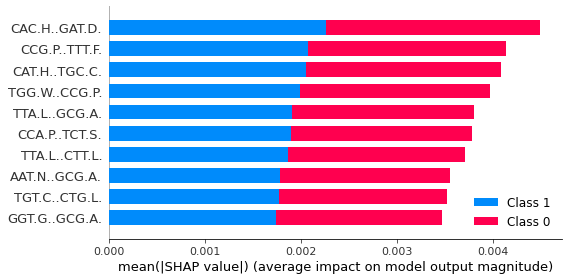

In [49]:
name = df_list[0]
shap_val = shap_values_list[0]
data = X_train_list[0]

print('\n                                Top 10 Important Features for {}'.format(name))
    
shap.summary_plot(shap_val, features=data, feature_names=feature_list, max_display=10, plot_size=[8,4])

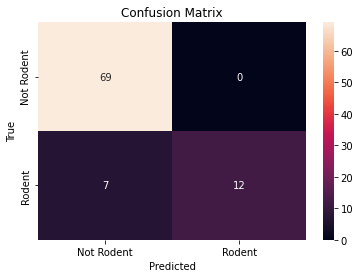

In [50]:
plot_cm(y_test_pred_list[0], y_test_truth_list[0], classLabels=['Not Rodent', 'Rodent'])

In [51]:
print_scores(y_test_pred_list, y_test_truth_list, index=0)

Accuracy: 0.9204545454545454
Precision: 0.9277811004784688
Recall: 0.9204545454545454
F1: 0.9133936697340478


# Vespbat Results


                                Top 10 Important Features for df_Vespbat


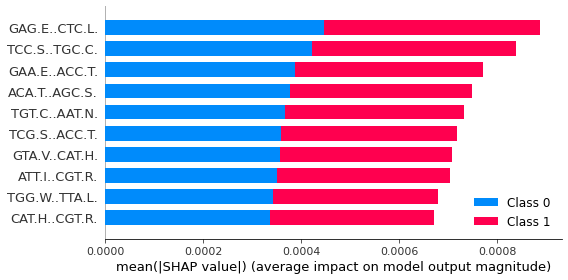

In [53]:
name = df_list[1]
shap_val = shap_values_list[1]
data = X_train_list[1]

print('\n                                Top 10 Important Features for {}'.format(name))
    
shap.summary_plot(shap_val, features=data, feature_names=feature_list, max_display=10, plot_size=[8,4])

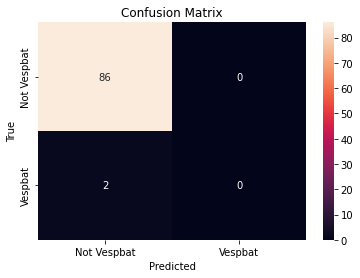

In [31]:
plot_cm(y_test_pred_list[1], y_test_truth_list[1], classLabels=['Not Vespbat', 'Vespbat'])

In [52]:
print_scores(y_test_pred_list, y_test_truth_list, index=1)

Accuracy: 0.9772727272727273
Precision: 0.9550619834710744
Recall: 0.9772727272727273
F1: 0.9660397074190178


# Artiodactyl Results


                                Top 10 Important Features for df_Artiodactyl


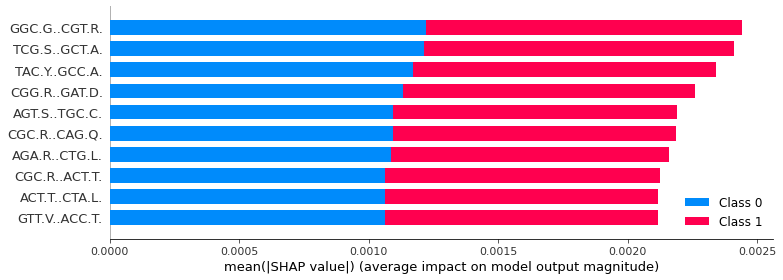

In [54]:
name = df_list[2]
shap_val = shap_values_list[2]
data = X_train_list[2]

print('\n                                Top 10 Important Features for {}'.format(name))
    
shap.summary_plot(shap_val, features=data, feature_names=feature_list, max_display=10, plot_size=[11,4])

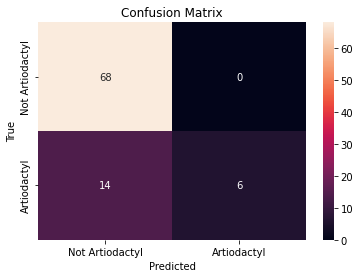

In [55]:
plot_cm(y_test_pred_list[2], y_test_truth_list[2], classLabels=['Not Artiodactyl', 'Artiodactyl'])

In [56]:
print_scores(y_test_pred_list, y_test_truth_list, index=2)

Accuracy: 0.8409090909090909
Precision: 0.8680709534368071
Recall: 0.8409090909090909
F1: 0.8055011655011655


# Pterobat Results


                                Top 10 Important Features for df_Pterobat


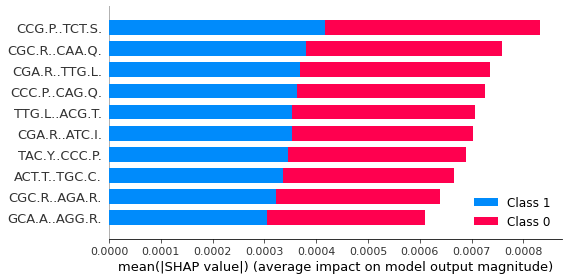

In [57]:
name = df_list[3]
shap_val = shap_values_list[3]
data = X_train_list[3]

print('\n                                Top 10 Important Features for {}'.format(name))
    
shap.summary_plot(shap_val, features=data, feature_names=feature_list, max_display=10, plot_size=[8,4])

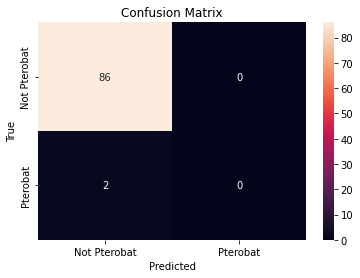

In [58]:
plot_cm(y_test_pred_list[3], y_test_truth_list[3], classLabels=['Not Pterobat', 'Pterobat'])

In [59]:
print_scores(y_test_pred_list, y_test_truth_list, index=3)

Accuracy: 0.9772727272727273
Precision: 0.9550619834710744
Recall: 0.9772727272727273
F1: 0.9660397074190178


# Primate Results


                                Top 10 Important Features for df_Primate


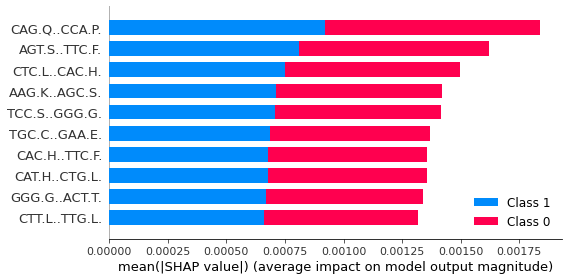

In [60]:
name = df_list[4]
shap_val = shap_values_list[4]
data = X_train_list[4]

print('\n                                Top 10 Important Features for {}'.format(name))
    
shap.summary_plot(shap_val, features=data, feature_names=feature_list, max_display=10, plot_size=[8,4])

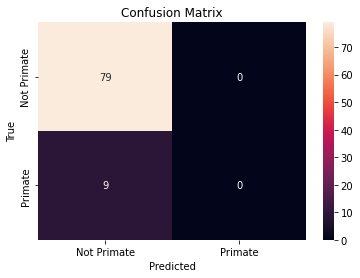

In [61]:
plot_cm(y_test_pred_list[4], y_test_truth_list[4], classLabels=['Not Primate', 'Primate'])

In [62]:
print_scores(y_test_pred_list, y_test_truth_list, index=4)

Accuracy: 0.8977272727272727
Precision: 0.8059142561983471
Recall: 0.8977272727272727
F1: 0.8493467610234078


# Plant Results


                                Top 10 Important Features for df_Plant


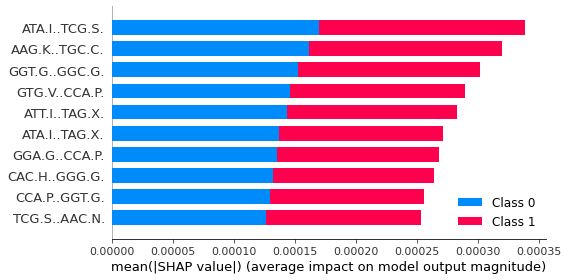

In [63]:
name = df_list[5]
shap_val = shap_values_list[5]
data = X_train_list[5]

print('\n                                Top 10 Important Features for {}'.format(name))
    
shap.summary_plot(shap_val, features=data, feature_names=feature_list, max_display=10, plot_size=[8,4])

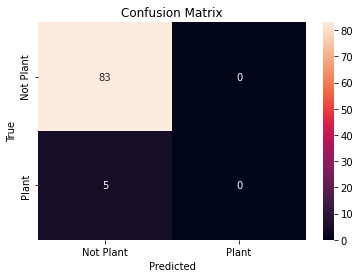

In [64]:
plot_cm(y_test_pred_list[5], y_test_truth_list[5], classLabels=['Not Plant', 'Plant'])

In [65]:
print_scores(y_test_pred_list, y_test_truth_list, index=5)

Accuracy: 0.9431818181818182
Precision: 0.8895919421487603
Recall: 0.9431818181818182
F1: 0.9156034024455078


# Insect Results


                                Top 10 Important Features for df_Insect


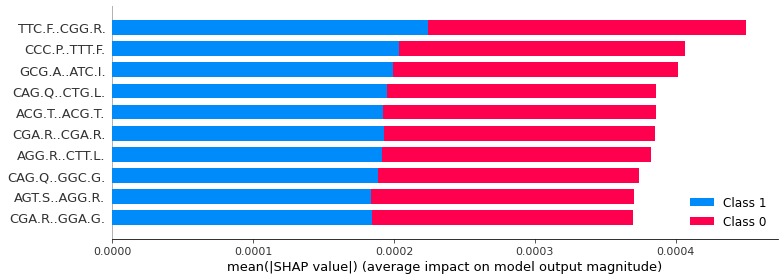

In [66]:
name = df_list[6]
shap_val = shap_values_list[6]
data = X_train_list[6]

print('\n                                Top 10 Important Features for {}'.format(name))
    
shap.summary_plot(shap_val, features=data, feature_names=feature_list, max_display=10, plot_size=[11,4])

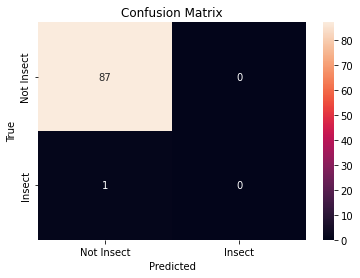

In [67]:
plot_cm(y_test_pred_list[6], y_test_truth_list[6], classLabels=['Not Insect', 'Insect'])

In [68]:
print_scores(y_test_pred_list, y_test_truth_list, index=6)

Accuracy: 0.9886363636363636
Precision: 0.9774018595041323
Recall: 0.9886363636363636
F1: 0.982987012987013


# Carnivore Results


                                Top 10 Important Features for df_Carnivore


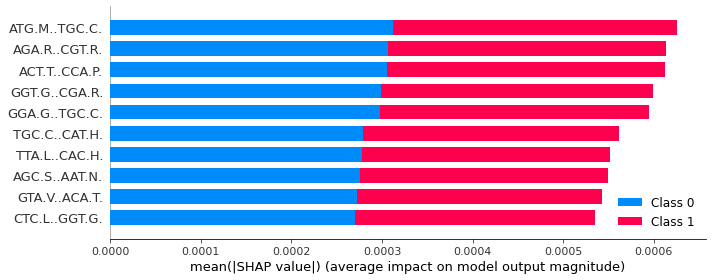

In [81]:
name = df_list[7]
shap_val = shap_values_list[7]
data = X_train_list[7]

print('\n                                Top 10 Important Features for {}'.format(name))
    
shap.summary_plot(shap_val, features=data, feature_names=feature_list, max_display=10, plot_size=[10,4])

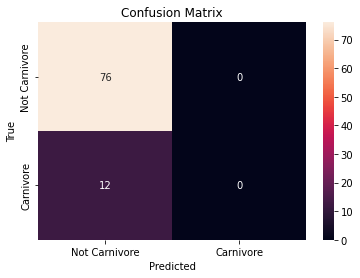

In [70]:
plot_cm(y_test_pred_list[7], y_test_truth_list[7], classLabels=['Not Carnivore', 'Carnivore'])

In [71]:
print_scores(y_test_pred_list, y_test_truth_list, index=7)

Accuracy: 0.8636363636363636
Precision: 0.7458677685950413
Recall: 0.8636363636363636
F1: 0.8004434589800443


# Fish Results


                                Top 10 Important Features for df_Fish


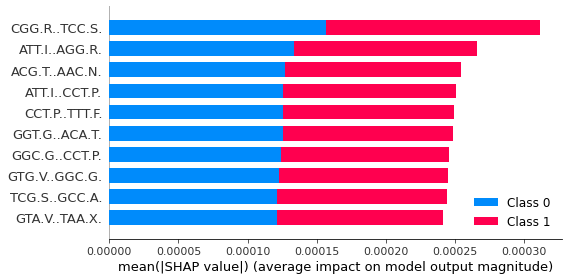

In [72]:
name = df_list[8]
shap_val = shap_values_list[8]
data = X_train_list[8]

print('\n                                Top 10 Important Features for {}'.format(name))
    
shap.summary_plot(shap_val, features=data, feature_names=feature_list, max_display=10, plot_size=[8,4])

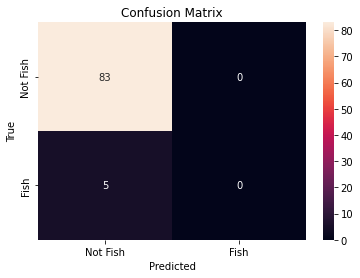

In [73]:
plot_cm(y_test_pred_list[8], y_test_truth_list[8], classLabels=['Not Fish', 'Fish'])

In [74]:
print_scores(y_test_pred_list, y_test_truth_list, index=9)

Accuracy: 0.9545454545454546
Precision: 0.9566353187042842
Recall: 0.9545454545454546
F1: 0.9399286987522281


# Galloanserae Results


                                Top 10 Important Features for df_Galloanserae


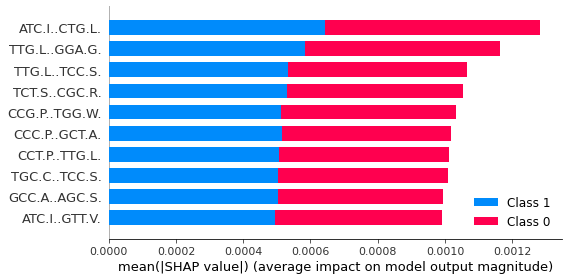

In [75]:
name = df_list[9]
shap_val = shap_values_list[9]
data = X_train_list[9]

print('\n                                Top 10 Important Features for {}'.format(name))
    
shap.summary_plot(shap_val, features=data, feature_names=feature_list, max_display=10, plot_size=[8,4])

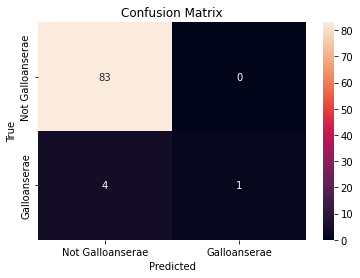

In [76]:
plot_cm(y_test_pred_list[9], y_test_truth_list[9], classLabels=['Not Galloanserae', 'Galloanserae'])

In [77]:
print_scores(y_test_pred_list, y_test_truth_list, index=9)

Accuracy: 0.9545454545454546
Precision: 0.9566353187042842
Recall: 0.9545454545454546
F1: 0.9399286987522281


# Neoaves Results


                                Top 10 Important Features for df_Neoaves


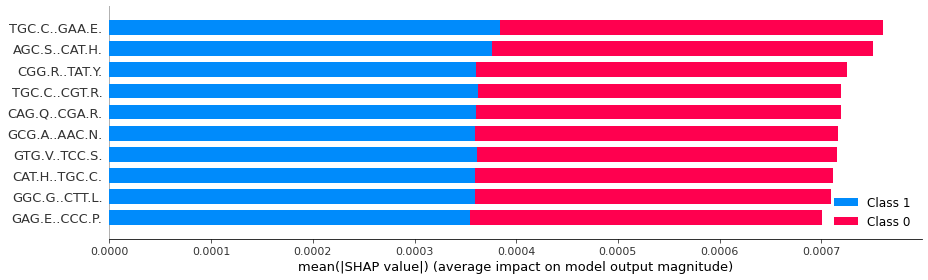

In [91]:
name = df_list[10]
shap_val = shap_values_list[10]
data = X_train_list[10]

print('\n                                Top 10 Important Features for {}'.format(name))
    
shap.summary_plot(shap_val, features=data, feature_names=feature_list, max_display=10, plot_size=[13,4])

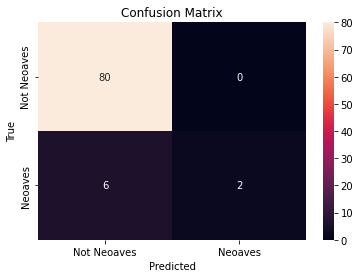

In [79]:
plot_cm(y_test_pred_list[10], y_test_truth_list[10], classLabels=['Not Neoaves', 'Neoaves'])

In [80]:
print_scores(y_test_pred_list, y_test_truth_list, index=10)

Accuracy: 0.9318181818181818
Precision: 0.9365750528541227
Recall: 0.9318181818181818
F1: 0.9125958378970427
